In [1]:
# # first time setup only
# #!python ./fetch_dataset.py
# #!unzip ./frames.zip # only for first time setup

# # mount the drive
# from google.colab import drive
# drive.mount('/content/drive', force_remount=False)

# # move to the git repo
# %cd /content/drive/Shareddrives/StellarSummarizers/the-stellar-summarizers-sp22

In [2]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()    # garbage collection

# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [3]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, ToPILImage, Resize, ConvertImageDtype
import torchvision.models as models
from torchvision.io import read_image
from torchvision.utils import make_grid
import torchvision.transforms.functional as F

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

image_transformation = nn.Sequential(
    Resize(size=(140, 320)),
    ConvertImageDtype(torch.float),
)
    
class SumMeDataset(Dataset):
    def __init__(self, annotations_filename, img_dir, transform=None, target_transform=None):

        self.annotation_filename = annotations_filename
        self.annotation = pd.read_csv(annotations_filename, header=0)

        self.img_dir = img_dir
        self.video_name = img_dir.split('/')[-1]
        self.frame_labels = self.annotation[self.annotation['video_name'] == self.video_name]['gt_score']

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frame_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, 'img_' + str(idx + 1).zfill(5) + '.jpg')
        image = read_image(img_path)
        label = self.frame_labels.iloc[idx]

        if self.transform:
            image = self.transform(image)
            image = image.to(device)
#         if self.target_transform:
#         label = label * 100
#             label = self.target_transform(label)

        return image, label, idx

def show(imgs):
    """Arrange images in a grid formation; helper function of make_grid"""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(20, 16))
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
# get device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using: {device.upper()}")

annotations_filename = './frames/annotation.csv'
annotations_filename = '../input/summeframes/frames/annotation.csv' # kaggle

batch_size = 80 # needs to be large enough

# instantiating the dataset
videos_root = './frames/Jumps'
videos_root = '../input/summeframes/frames/Jumps' # kaggle
dataset = SumMeDataset(annotations_filename, videos_root, transform=image_transformation)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{videos_root} dataset has {len(dataset)} samples')

videos_root = '../input/summeframes/frames/Base_jumping' # Kaggle
dataset2 = SumMeDataset(annotations_filename, videos_root, transform=image_transformation)
dataloader2 = DataLoader(dataset2, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{videos_root} dataset has {len(dataset2)} samples')

videos_root = '../input/summeframes/frames/Valparaiso_Downhill' # kaggle
dataset3 = SumMeDataset(annotations_filename, videos_root, transform=image_transformation)
dataloader3 = DataLoader(dataset2, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{videos_root} dataset has {len(dataset3)} samples')


# features, labels = next(iter(dataloader))
# print("Data Loader:")
# print(f"Feature batch shape: {features.size()}")
# print(f"Labels batch shape: {labels.size()}")

# load validation dataset too
validation_video_root = './frames/Cooking'
validation_video_root = '../input/summeframes/frames/Cooking'

validation_dataset = SumMeDataset(annotations_filename, validation_video_root, transform=image_transformation)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
print(f'{validation_video_root} dataset has {len(validation_dataset)} samples')

print(dataset[0][0].shape)
feature, label, _ = dataset[256]
label

Using: CUDA
../input/summeframes/frames/Jumps dataset has 950 samples
../input/summeframes/frames/Base_jumping dataset has 4729 samples
../input/summeframes/frames/Valparaiso_Downhill dataset has 5178 samples
../input/summeframes/frames/Cooking dataset has 1286 samples
torch.Size([3, 140, 320])


0.3333333333333333

## Encoder

In [5]:
# encoder
feature_size = 256

class new_resNext(torch.nn.Module):
    def __init__(self, fc_size=2048, large=False, pretrained=True):
        super(new_resNext,self).__init__()
        if large:
            self.model = models.resnext101_32x8d(pretrained=pretrained)
        else:
            self.model = models.resnext50_32x4d(pretrained=pretrained)

        self.model.fc = torch.nn.Linear(fc_size, feature_size)

    def forward(self,x):
        x = self.model(x)
        return x

new_resNext = new_resNext().to(device) # models move to different device inplace

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


  0%|          | 0.00/95.8M [00:00<?, ?B/s]

## RNN

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers

        # defining the layers
        self.rnn = nn.LSTM(input_size, hidden_size, n_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 16)
        self.out = nn.Linear(16, output_size)

    def forward(self, input):
        output, hidden = self.rnn(input)
        output = self.fc1(output)
        output = self.fc2(output)
        output = self.fc3(output)
        output = self.out(output)

        return output, hidden


# want more hidden_size (up to 1024)
# 2-4 layers
model = Model(feature_size, 1, 512, 4)
model.to(device)

def loss_func(pred, y):
    if (y > 0.5).any():
        return nn.MSELoss()(pred, y) * 2
    elif (y > 0.75).any():
        return nn.MSELoss()(pred, y) * 4
    else:
        return nn.MSELoss()(pred, y)
    

# define loss and optimizer
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

load = True # swtich this when evaulating
if load:
    model = torch.load("../input/trained-model/trained_model-20220530-081750")
    print(model.eval())

Model(
  (rnn): LSTM(256, 512, num_layers=4, batch_first=True)
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (out): Linear(in_features=16, out_features=1, bias=True)
)


## Training

In [7]:
from tqdm.notebook import tqdm

def test_loop(dataloader, model, num_samples):
    """Iterate through the whole dataset and calculate average loss"""
    test_loss = 0
    preds = np.zeros(num_samples) - 1

    with torch.no_grad():
        for features, labels, idxs in tqdm(dataloader):

            # encode the features
            features = features.to(device)
            labels = labels.to(device)
            labels = torch.reshape(labels, (1, batch_size, 1))

            encoded_features = new_resNext(features)
            batched_seq = torch.reshape(encoded_features, (1, batch_size, feature_size))

            pred, _= model(batched_seq)
            test_loss += loss_func(pred, labels.float()).item()

            for index, pred in zip(idxs, torch.flatten(pred)):
                preds[index] = pred

    test_loss /= batch_size
    print(f'test_loss = {test_loss}')
    return test_loss, preds

# TRAINING LOOP
def train_loop(dataloaders, model):
    """One iteration of training"""
    train_loss = 0 
    for dataloader in dataloaders:
        for features, labels, _ in tqdm(dataloader):

            # move features and labels to GPU
            features = features.to(device) # data doesn't move to different device inplace ! 
            labels = labels.to(device)
            labels = torch.reshape(labels, (1, batch_size, 1))

            optimizer.zero_grad()

            # encode image features using resNext and reshape
            encoded_features = new_resNext(features)
            batched_seq = torch.reshape(encoded_features, (1, batch_size, feature_size))
            batched_seq.to(device)

            output, hidden = model(batched_seq) # forward pass
            loss = criterion(output, labels.float()) # calcualte MSE
#             print(loss)
            train_loss += loss
            loss.backward()
            optimizer.step()
    
        train_loss /= batch_size
        print(f'training_loss = {train_loss}')

# Train for num_epochs
if not load: # if didn't load the model weights, train
    num_epochs = 5
    dataloaders = [dataloader, dataloader2, dataloader3] # add new dataloader here
    for epoch in range(num_epochs):
        print(f'epoch {epoch}')
        train_loop(dataloaders, model)
        test_loss, preds = test_loop(validation_dataloader, model, len(validation_dataset))

## Testing

In [8]:
test_loss, preds = test_loop(dataloader, model, len(dataset))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values

  0%|          | 0/11 [00:00<?, ?it/s]

test_loss = 0.017798062493966427
min: 0.055271800607442856 
max: 0.08140027523040771 
avg: -0.020137251195938965 
median: 0.05541676841676235 0


0.0814 0.33333
0.07877 0.06667
0.07721 0.13333
0.07677 0.4
0.07627 0.0
0.07613 0.0
0.07607 0.0
0.076 0.93333
0.07541 0.0
0.07532 0.06667


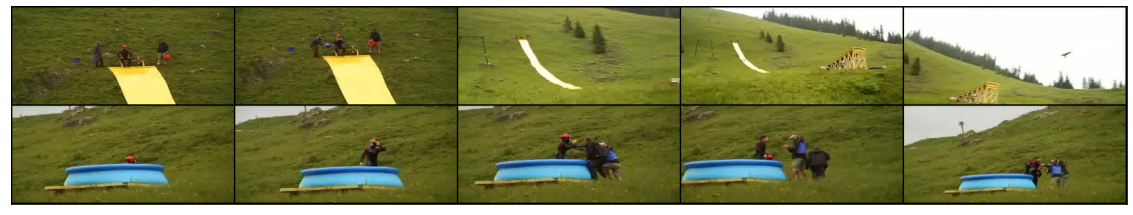

In [9]:
def visualize_results(preds, dataset, num_frames=5):
    
    # find top ranked frames
    selected_img_i = []
    top_imgs_i = np.argsort(preds)
    selected = np.zeros(len(preds))
    for img_i in reversed(top_imgs_i):
        if selected[img_i] != 1:
            selected[img_i-len(dataset)//20 : img_i+len(dataset)//20] = 1
            feature, label, _ = dataset[img_i]
            print(round(preds[img_i], 5), round(label, 5))
            selected_img_i.append(img_i)
        if len(selected_img_i) >= num_frames:
            break
    
    best_features = []
    for idx in np.sort(selected_img_i):
        feature, label, _ = dataset[idx]
        best_features.append(feature)
    grid = make_grid(best_features, nrow=5)
#     show(grid)
        
#     # used during tuning
#     top_imgs_i = np.argsort(preds)[-10:]
#     for img_i in reversed(top_imgs_i):
#         feature, label, _ = dataset[img_i]
#         print(img_i, preds[img_i], label)
#         best_feature.append(feature)
        
#     grid = make_grid(best_feature, nrow=5)
    show(grid)

visualize_results(preds, dataset, num_frames=10)

  0%|          | 0/59 [00:00<?, ?it/s]

test_loss = 0.029818409632389374
min: 0.050019070506095886 
max: 0.08052331954240799 
avg: 0.05564239209797096 
median: 0.055514559149742126 0
0.08052 0.27778
0.0802 0.0
0.07959 0.11111
0.07861 0.16667
0.07761 0.27778
0.07724 0.0
0.07721 0.16667
0.07668 0.0
0.07663 0.0
0.07656 0.38889


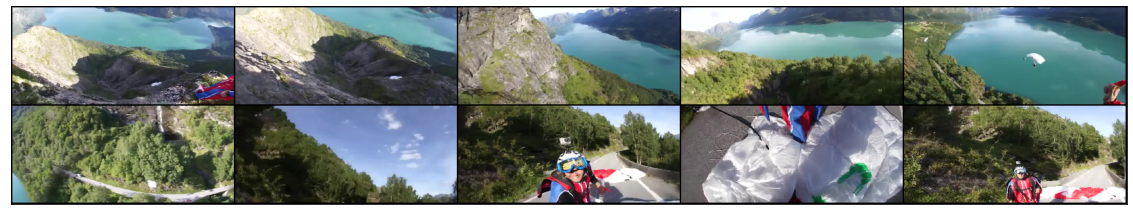

In [10]:
test_loss, preds = test_loop(dataloader2, model, len(dataset2))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values
visualize_results(preds, dataset2, num_frames=10)

  0%|          | 0/59 [00:00<?, ?it/s]

test_loss = 0.029818409632389374
min: 0.050019070506095886 
max: 0.08052331954240799 
avg: -0.03589554418089906 
median: 0.055437348783016205 0
0.08052 0.06667
0.0802 0.0
0.07959 0.0
0.07861 0.33333
0.07761 0.2
0.07724 0.06667
0.07668 0.0
0.07618 0.2
0.07617 0.06667
0.07592 0.13333


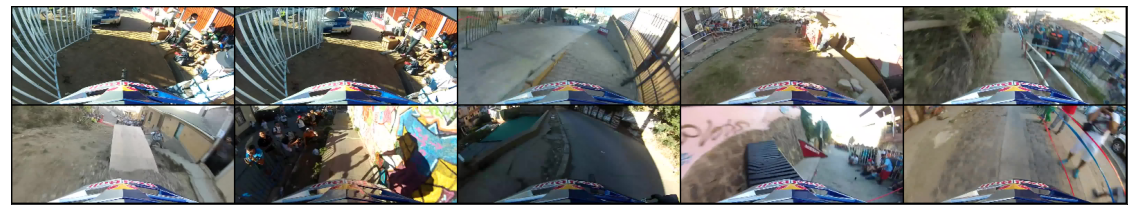

In [11]:
test_loss, preds = test_loop(dataloader3, model, len(dataset3))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values
visualize_results(preds, dataset3, num_frames=10)

  0%|          | 0/16 [00:00<?, ?it/s]

test_loss = 0.016426429288549114
min: 0.05538075044751167 
max: 0.08119545876979828 
avg: 0.05264271117318103 
median: 0.05545863322913647 0
0.0812 0.0
0.07968 0.05882
0.07676 0.05882
0.07645 0.0
0.0764 0.58824
0.07618 0.05882
0.07617 0.0
0.07615 0.05882
0.07614 0.0
0.0761 0.0


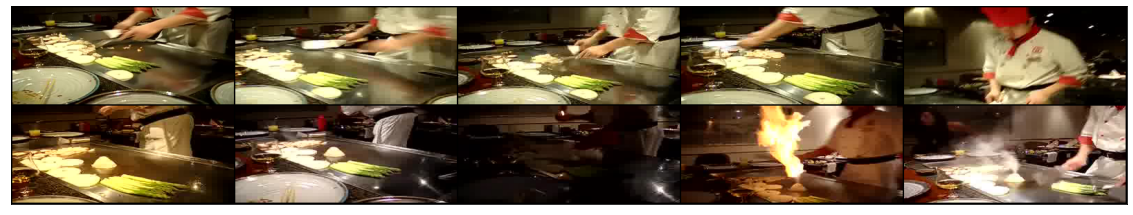

In [12]:
test_loss, preds = test_loop(validation_dataloader, model, len(validation_dataset))
print("min:", np.min(preds[preds != -1]), "\nmax:", np.max(preds), "\navg:", np.average(preds), "\nmedian:", np.median(preds), len(preds[preds > 0.5])) # show the stats of predicted values
visualize_results(preds, validation_dataset, num_frames=10)

In [13]:
# torch.save(model.state_dict(), "./saved_model_3_dataset")

In [14]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S")
torch.save(model, "./trained_model-" + timestr)

In [15]:
# if load:
#     model = torch.load("./model_3_dataset")
#     model.eval()